# Coach IA Powerlifting - Notebook de recherche

## Imports & configuration

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
import time

from sklearn.model_selection import RandomizedSearchCV
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

## Chargement des données

In [60]:
df = pd.read_csv(
    "database/openpowerlifting-2024-01-06-4c732975.csv",
    low_memory=False
)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3043013 entries, 0 to 3043012
Data columns (total 41 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Name              object 
 1   Sex               object 
 2   Event             object 
 3   Equipment         object 
 4   Age               float64
 5   AgeClass          object 
 6   BirthYearClass    object 
 7   Division          object 
 8   BodyweightKg      float64
 9   WeightClassKg     object 
 10  Squat1Kg          float64
 11  Squat2Kg          float64
 12  Squat3Kg          float64
 13  Squat4Kg          float64
 14  Best3SquatKg      float64
 15  Bench1Kg          float64
 16  Bench2Kg          float64
 17  Bench3Kg          float64
 18  Bench4Kg          float64
 19  Best3BenchKg      float64
 20  Deadlift1Kg       float64
 21  Deadlift2Kg       float64
 22  Deadlift3Kg       float64
 23  Deadlift4Kg       float64
 24  Best3DeadliftKg   float64
 25  TotalKg           float64
 26  Place         

,Name,Sex,Event,Equipment,Age,AgeClass,BirthYearClass,Division,BodyweightKg,WeightClassKg,...,Tested,Country,State,Federation,ParentFederation,Date,MeetCountry,MeetState,MeetTown,MeetName
0,Alona Vladi,F,SBD,Raw,33.0,24-34,24-39,O,58.30,60,...,Yes,Russia,NaN,GFP,NaN,2019-05-11,Russia,NaN,Bryansk,Open Tournament
1,Galina Solovyanova,F,SBD,Raw,43.0,40-44,40-49,M1,73.10,75,...,Yes,Russia,NaN,GFP,NaN,2019-05-11,Russia,NaN,Bryansk,Open Tournament
2,Daniil Voronin,M,SBD,Raw,15.5,16-17,14-18,T,67.40,75,...,Yes,Russia,NaN,GFP,NaN,2019-05-11,Russia,NaN,Bryansk,Open Tournament
3,Aleksey Krasov,M,SBD,Raw,35.0,35-39,24-39,O,66.65,75,...,Yes,Russia,NaN,GFP,NaN,2019-05-11,Russia,NaN,Bryansk,Open Tournament
4,Margarita Pleschenkova,M,SBD,Raw,26.5,24-34,24-39,O,72.45,75,...,Yes,Russia,NaN,GFP,NaN,2019-05-11,Russia,NaN,Bryansk,Open Tournament


## Nettoyage et filtrage des données

In [61]:
df = df[df["Event"] == "SBD"]
df = df[df["Equipment"] == "Raw"]

df_copy = df[["Sex", "Age", "BodyweightKg",
              "Best3SquatKg", "Best3BenchKg", "Best3DeadliftKg", "TotalKg"]]

df_copy = df_copy[~df_copy["Sex"].str.upper().eq("MX")]

df_copy = df_copy.dropna()

print(df_copy.head())
df_copy.info()


  Sex   Age  BodyweightKg  Best3SquatKg  Best3BenchKg  Best3DeadliftKg  \
0   F  33.0         58.30          80.0          60.0            107.5   
1   F  43.0         73.10         105.0          67.5            110.0   
2   M  15.5         67.40         100.0          62.5            105.0   
3   M  35.0         66.65         137.5         122.5            170.0   
4   M  26.5         72.45          90.0          50.0            125.0   

   TotalKg  
0    247.5  
1    282.5  
2    267.5  
3    430.0  
4    265.0  
<class 'pandas.core.frame.DataFrame'>
Index: 634502 entries, 0 to 3042038
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Sex              634502 non-null  object 
 1   Age              634502 non-null  float64
 2   BodyweightKg     634502 non-null  float64
 3   Best3SquatKg     634502 non-null  float64
 4   Best3BenchKg     634502 non-null  float64
 5   Best3DeadliftKg  634502 non-null  flo

## Analyse exploratoire des données (EDA)

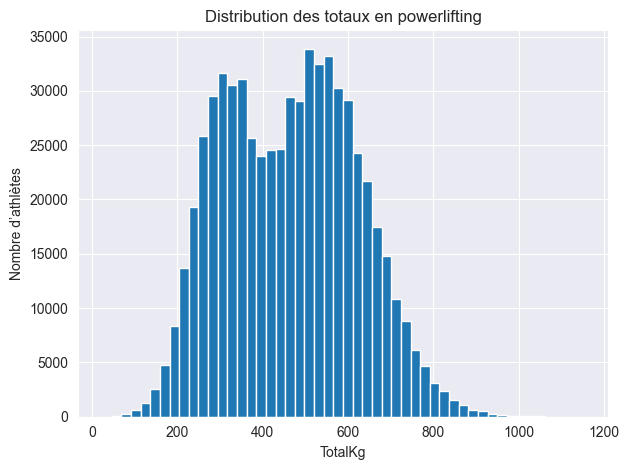

In [78]:
df_copy['TotalKg'].hist(bins=50)
plt.xlabel('TotalKg')
plt.ylabel('Nombre d’athlètes')
plt.title('Distribution des totaux en powerlifting')
plt.tight_layout()
plt.show()

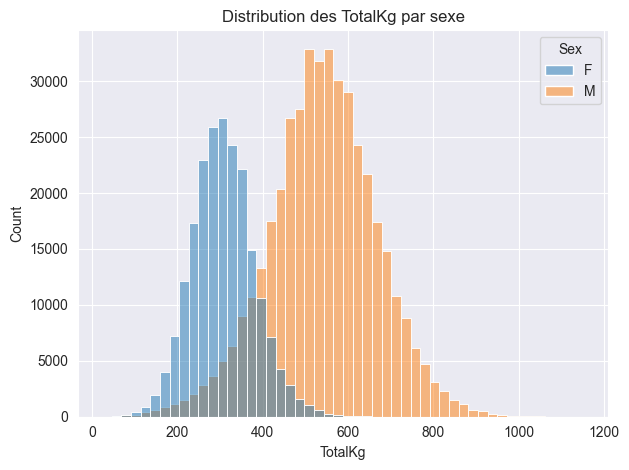

In [63]:
sns.histplot(data=df_copy, x="TotalKg", hue="Sex", bins=50)
plt.title("Distribution des TotalKg par sexe")
plt.xlabel("TotalKg")
plt.tight_layout()
plt.show()

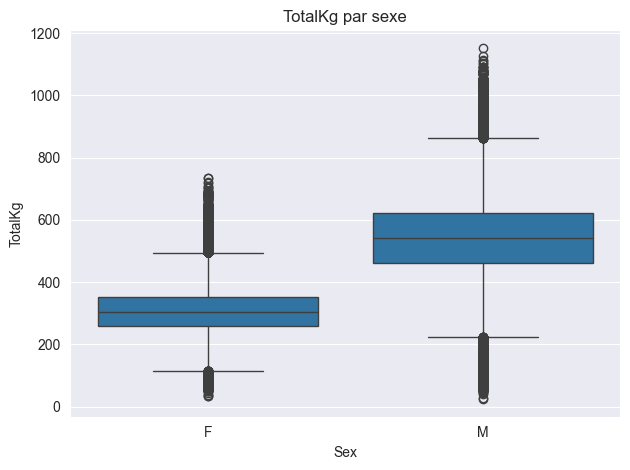

In [64]:
sns.boxplot(x="Sex", y="TotalKg", data=df_copy)
plt.title("TotalKg par sexe")
plt.tight_layout()
plt.show()

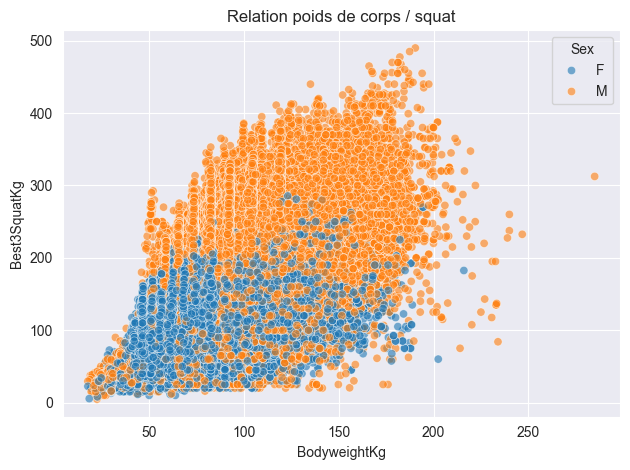

In [65]:
sns.scatterplot(data=df_copy, x="BodyweightKg", y="Best3SquatKg", hue="Sex", alpha=0.6)
plt.title("Relation poids de corps / squat")
plt.tight_layout()
plt.show()

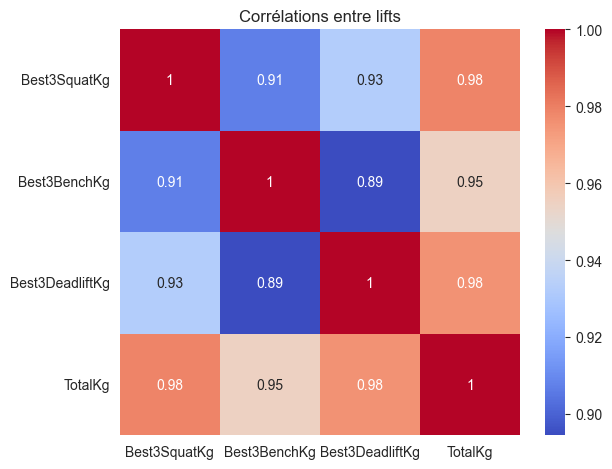

In [66]:
num_cols = ["Best3SquatKg", "Best3BenchKg", "Best3DeadliftKg", "TotalKg"]

sns.heatmap(df_copy[num_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Corrélations entre lifts")
plt.tight_layout()
plt.show()

## Préparation des données pour le machine learning

In [67]:
FEATURES = ["Sex", "Age", "BodyweightKg"]
TARGETS = ["Best3SquatKg", "Best3BenchKg", "Best3DeadliftKg"]

X = df_copy[FEATURES]
y = df_copy[TARGETS]

preprocess = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(drop="first"), ["Sex"])],
    remainder="passthrough"
)

## Modèle de base – XGBoost (baseline)

In [68]:
models = {}

for target in TARGETS:
    model = Pipeline(steps=[
        ("preprocess", preprocess),
        ("regressor", XGBRegressor(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=5,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42
        ))
    ])
    model.fit(X, df_copy[target])
    models[target] = model

In [69]:
for target in TARGETS:
    preds = models[target].predict(X)
    mae = mean_absolute_error(df_copy[target], preds)
    print(f"{target} – MAE : {mae:.2f} kg")

Best3SquatKg – MAE : 24.67 kg
Best3BenchKg – MAE : 16.09 kg
Best3DeadliftKg – MAE : 24.68 kg


## Comparaison de modèles et optimisation globale

In [70]:
df_sample = df_copy.sample(frac=0.20, random_state=42)

X_sample = df_sample[FEATURES]
y_sample = df_sample[TARGETS]

### XGBoost – MultiOutput + RandomizedSearchCV

In [71]:
xgb_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("regressor", MultiOutputRegressor(
        XGBRegressor(n_jobs=1, random_state=42)
    ))
])

xgb_param_grid = {
    "regressor__estimator__n_estimators": [300, 500, 800],
    "regressor__estimator__learning_rate": [0.01, 0.05, 0.1],
    "regressor__estimator__max_depth": [3, 5, 6],
    "regressor__estimator__subsample": [0.7, 0.8, 0.9]
}

start = time.time()
xgb_search = RandomizedSearchCV(
    xgb_model,
    xgb_param_grid,
    n_iter=5,
    scoring="neg_mean_absolute_error",
    cv=3,
    n_jobs=-1,
    random_state=42
)
xgb_search.fit(X_sample, y_sample)

xgb_best_mae = -xgb_search.best_score_
print(f"XGBoost – MAE globale : {xgb_best_mae:.2f} kg")

XGBoost – MAE globale : 21.89 kg


### CatBoost – MultiOutput + RandomizedSearchCV

In [72]:
X_cb = pd.get_dummies(X_sample, columns=["Sex"], drop_first=True)

cb_model = MultiOutputRegressor(
    CatBoostRegressor(
        verbose=0,
        allow_writing_files=False,
        random_state=42
    )
)

cb_param_grid = {
    "estimator__iterations": [300, 500, 800],
    "estimator__learning_rate": [0.01, 0.05, 0.1],
    "estimator__depth": [4, 6, 8],
    "estimator__l2_leaf_reg": [1, 3, 5]
}

cb_search = RandomizedSearchCV(
    cb_model,
    cb_param_grid,
    n_iter=5,
    scoring="neg_mean_absolute_error",
    cv=3,
    n_jobs=-1,
    random_state=42
)
cb_search.fit(X_cb, y_sample)

cb_best_mae = -cb_search.best_score_
print(f"CatBoost – MAE globale : {cb_best_mae:.2f} kg")

CatBoost – MAE globale : 21.88 kg


## Comparaison des performances globales

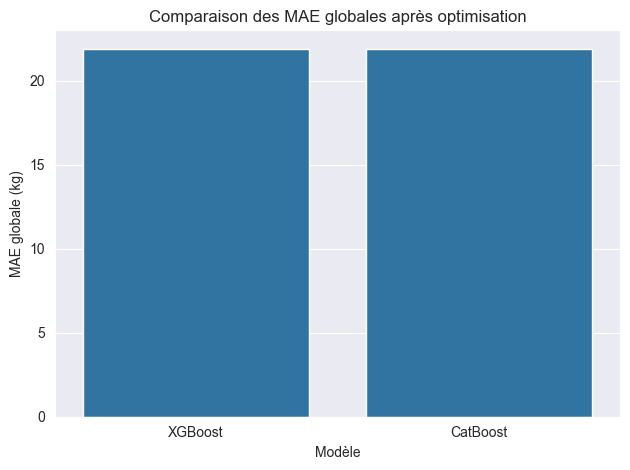

In [73]:
performance = pd.DataFrame({
    "Modèle": ["XGBoost", "CatBoost"],
    "MAE globale (kg)": [xgb_best_mae, cb_best_mae]
})

sns.barplot(data=performance, x="Modèle", y="MAE globale (kg)")
plt.title("Comparaison des MAE globales après optimisation")
plt.tight_layout()
plt.show()

## Analyse des résultats de la recherche d’hyperparamètres

Objectif :
- analyser la stabilité des modèles pendant la phase d’optimisation,
- comparer les distributions de performances au-delà de la meilleure MAE,
- observer l’influence de certains hyperparamètres sur les performances.

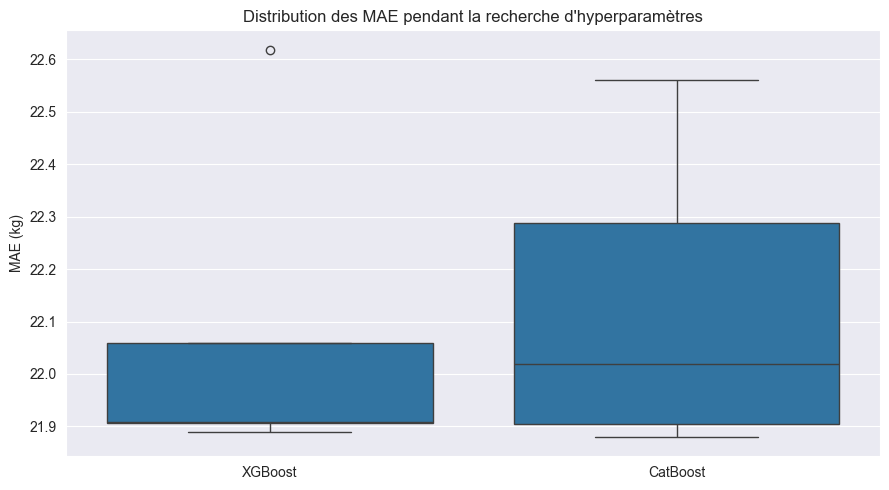

In [74]:
xgb_results = pd.DataFrame(xgb_search.cv_results_)
cb_results = pd.DataFrame(cb_search.cv_results_)

xgb_results["Modèle"] = "XGBoost"
cb_results["Modèle"] = "CatBoost"

cv_results = pd.concat([xgb_results, cb_results])
cv_results["MAE"] = -cv_results["mean_test_score"]

plt.figure(figsize=(9, 5))
sns.boxplot(
    data=cv_results,
    x="Modèle",
    y="MAE"
)
plt.title("Distribution des MAE pendant la recherche d'hyperparamètres")
plt.ylabel("MAE (kg)")
plt.xlabel("")
plt.tight_layout()
plt.show()

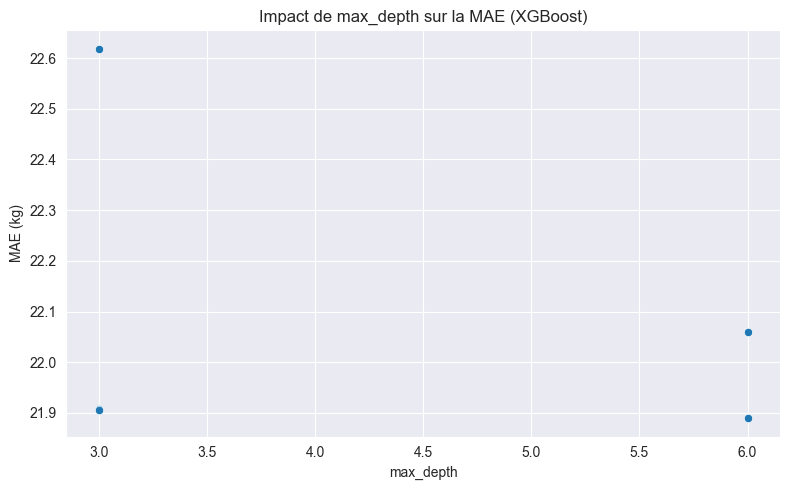

In [75]:
xgb_results["MAE"] = -xgb_results["mean_test_score"]

plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=xgb_results,
    x="param_regressor__estimator__max_depth",
    y="MAE"
)
plt.title("Impact de max_depth sur la MAE (XGBoost)")
plt.xlabel("max_depth")
plt.ylabel("MAE (kg)")
plt.tight_layout()
plt.show()

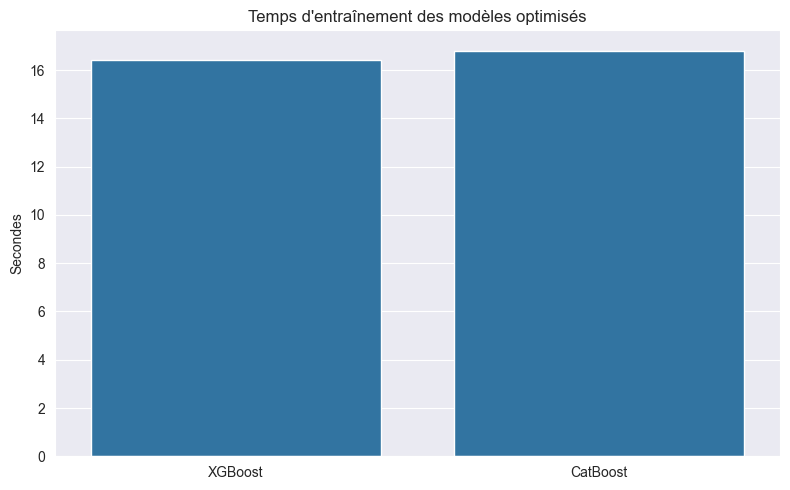

In [76]:
timing = pd.DataFrame({
    "Modèle": ["XGBoost", "CatBoost"],
    "Temps (s)": [
        xgb_search.refit_time_,
        cb_search.refit_time_
    ]
})

plt.figure(figsize=(8, 5))
sns.barplot(data=timing, x="Modèle", y="Temps (s)")
plt.title("Temps d'entraînement des modèles optimisés")
plt.ylabel("Secondes")
plt.xlabel("")
plt.tight_layout()
plt.show()

À l’issue de cette phase d’analyse, le modèle XGBoost est retenu
pour son compromis entre précision, stabilité et temps d’entraînement.

## Sélection du modèle final et évaluation sur jeu de test

In [77]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("XGBoost optimisé – MAE sur jeu de test")

for target in TARGETS:
    model_final = Pipeline(steps=[
        ("preprocess", preprocess),
        ("regressor", XGBRegressor(
            n_estimators=500,
            learning_rate=0.01,
            max_depth=6,
            subsample=0.8,
            random_state=42
        ))
    ])
    model_final.fit(X_train, y_train[target])
    preds = model_final.predict(X_test)
    mae = mean_absolute_error(y_test[target], preds)
    print(f"{target} – MAE : {mae:.2f} kg")


XGBoost optimisé – MAE sur jeu de test
Best3SquatKg – MAE : 24.73 kg
Best3BenchKg – MAE : 16.14 kg
Best3DeadliftKg – MAE : 24.71 kg
